## Linear Regression

In [20]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from itertools import repeat
import sympy
%matplotlib inline
#spline param approximation

## Tools

In [21]:
#visualization method
def visualize(X,Y,X_test,Y_test,Y_pred=[]):
    plt.figure(figsize=(20,10))
    
    plt.plot(X,Y,'ro',label='train points')
    plt.plot(X_test,Y_test,'go',label='test points')
    
    if Y_pred:
        plt.plot(X_test,Y_pred,'#222222',label = 'regression line')
    
    plt.legend()
    plt.axis([-2.25, 2.25, -0.25, 1.25])
    plt.show()

In [22]:
#test functions
def x_func_1_train(x,n):
    return 4*(x-1)/(n-1)-2
def x_func_1_test(x,n):
    return 4*(x-0.5)/(n-1)-2
def y_func_1(x):
    return 1/(1+25*x*x)

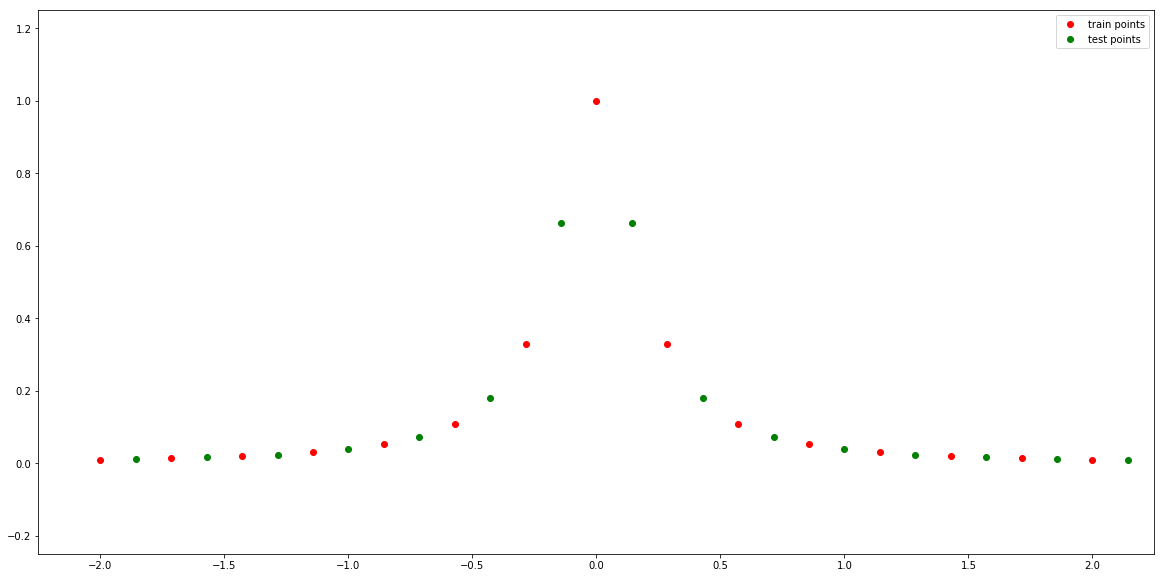

In [23]:
n = 15 #number of data points
x_train,x_test = [x_func_1_train(i,n) for i in range(1,n+1)],[x_func_1_test(i,n) for i in range(1,n+1)]
y_train,y_test = [y_func_1(i) for i in x_train],[y_func_1(i) for i in x_test]
func_1 = {
    'X_train' : x_train,
    'Y_train' : y_train,
    'X_test' : x_test,
    'Y_test' : y_test
}
visualize(func_1['X_train'],func_1['Y_train'],func_1['X_test'],func_1['Y_test'])

## I. Lagrange polynomial

In [8]:
#incorrect implementation: fits using test data, unable to generate an equation itself, computationally inefficient
def primitiveLagrange(X,Y,x_pred):
    res = 0
    n = len(X)
    for i in range(n):
        def L(i):
            Lv = 1
            for j in range(n):
                if i!=j:
                    Lv *= (x_pred - X[j])/(X[i]-X[j])
            return Lv
        res+=Y[i]*L(i)
    return res
def primitiveLagrange_test(X_train,Y_train,X_test,Y_test):
    Y_pred = [primitiveLagrange(X_train,Y_train,x_pred) for x_pred in X_test]
    loss = mean_squared_error(Y_test,Y_pred)
    print(loss)
    visualize(X_train,Y_train,X_test,Y_test,Y_pred)

In [9]:
#correct implementation: fit using train, generate an equation, then use to evaluate test
def LagrangePolynomial_fit(X,Y):
    x,n = sympy.Symbol('x'),len(X)
    function = 0
    for i in range(n):
        def L(i):
            Lv = 1
            for j in range(n):
                if i!=j:
                    Lv*=(x - X[j])/(X[i]-X[j])
            return Lv
        function+=Y[i]*L(i)
        function = function.simplify()
    return function
def LagrangePolynomial_predict(x,function):
    return function.subs({'x':x})

In [10]:
def testLagrange(X_train,Y_train,X_test,Y_test):
    lagrange_func = LagrangePolynomial_fit(X_train,Y_train)
    Y_pred = [LagrangePolynomial_predict(x,lagrange_func) for x in X_test]
    loss = mean_squared_error(Y_test,Y_pred)
    print("Lagrange polynomial: {0}\nLoss: {1}".format(lagrange_func,loss))
    visualize(X_train,Y_train,X_test,Y_test,Y_pred)

Lagrange polynomial: -0.85895812238967*x**14 - 3.55458562161393e-15*x**13 + 9.85102258077754*x**12 + 5.04491197081405e-14*x**11 - 43.1065474206605*x**10 + 1.61500234843389e-13*x**9 + 91.2616786737447*x**8 - 8.19792367670602e-15*x**7 - 98.0752141359998*x**6 - 4.32596016300413e-13*x**5 + 51.5382085217471*x**4 + 1.55100372378324e-14*x**3 - 11.8228815022526*x**2 - 7.8288396578518e-16*x + 1.0
Loss: 17955.71106456325


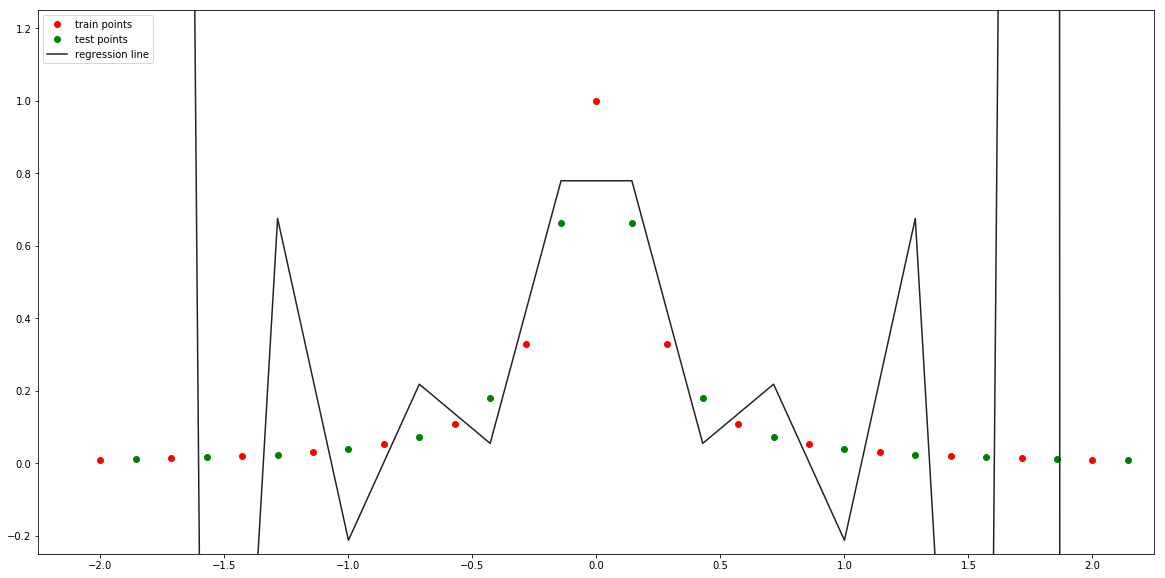

In [11]:
testLagrange(func_1['X_train'],func_1['Y_train'],func_1['X_test'],func_1['Y_test'])

## II. Ordinary Least squares

In [12]:
def OLS_fit(X,Y):
    x_mean, y_mean = sum(X)/len(X), sum(Y)/len(Y)
    m = sum((x-x_mean)*(y-y_mean) for x,y in zip(X,Y))/sum((x-x_mean)**2 for x in X)
    b = y_mean - m * x_mean
    return m,b

def OLS_predict(x,m,b):
    return m*x+b

In [13]:
def test_OLS(X_train,Y_train,X_test,Y_test):
    m,b = OLS_fit(X_train,Y_train)
    Y_pred = [OLS_predict(i,m,b) for i in X_test]
    error = mean_squared_error(Y_test,Y_pred)
    visualize(X_train,Y_train,X_test,Y_test,Y_pred)
    print('mse = {0}'.format(error))

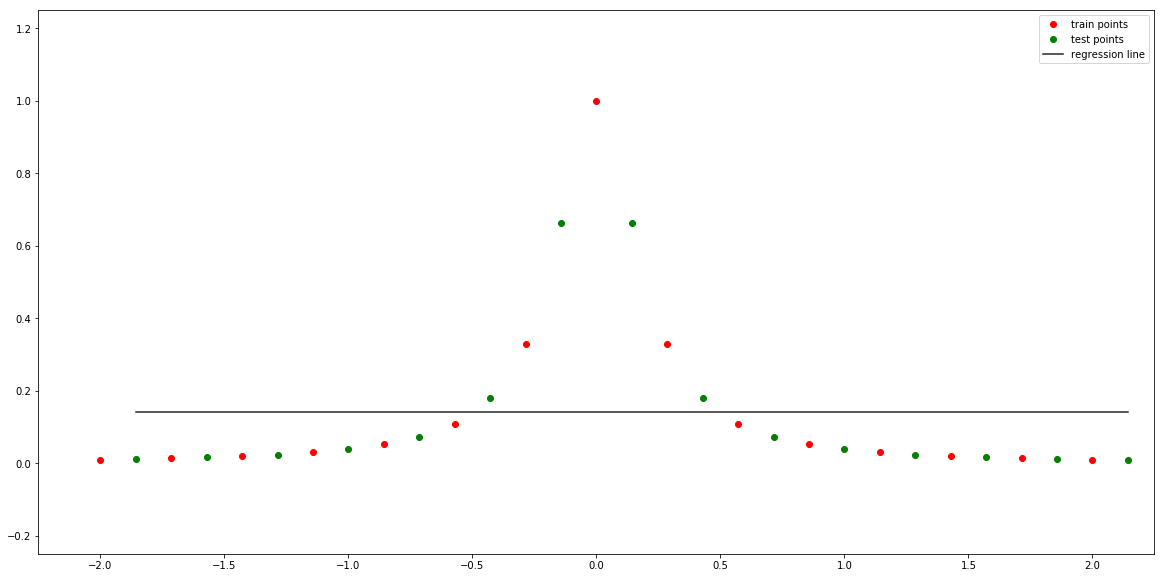

mse = 0.0457650082446857


In [14]:
test_OLS(func_1['X_train'],func_1['Y_train'],func_1['X_test'],func_1['Y_test'])

## III. Linear regression using Gradient Descent

In [15]:
def GD_fit(X,Y,l=0.0001,epochs = 1000):
    """
    Arguments:
    l -- learning rate
    epochs -- number of iterations
    X -- training set of X
    Y -- training set of Y
    Output:
    m,b -- params of Y = m*X+b - m is the slope, b is the intercept
    """
    m,b =0,0 #initial values
     
    for i in range(epochs):
        Y_pred = [m*x_i+b for x_i in X]
        D_m = (-2/n) * sum(x_i *(y_i-y_pred_i) for x_i,y_i,y_pred_i in zip(X,Y,Y_pred))
        D_b = (-2/n) * sum(y-y_i for y,y_i in zip(Y,Y_pred))
        m-=l*D_m
        b-=l*D_b
    return m,b


def GD_predict(x,m,b):
    return m*x + b


def test_GD(X_train,Y_train,X_test,Y_test):
    m,b = GD_fit(X_train,Y_train,0.001,1200)
    Y_pred = [GD_predict(i,m,b) for i in X_test]
    loss = mean_squared_error(Y_test,Y_pred)
    print("loss = {0}".format(loss))
    visualize(X_train,Y_train,X_test,Y_test,Y_pred)

loss = 0.0457433588975993


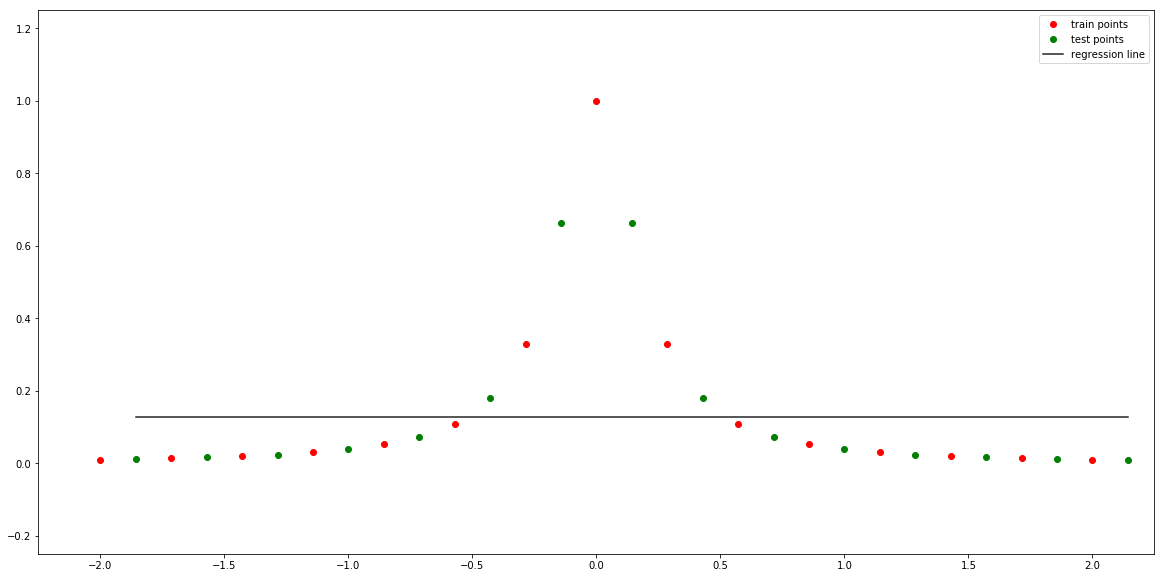

In [16]:
test_GD(func_1['X_train'],func_1['Y_train'],func_1['X_test'],func_1['Y_test'])

### Adding polynomial features

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
def polynomial_regression_fit(X,Y,d):
    poly_features = PolynomialFeatures(degree = d)
    X_poly = poly_features.fit_transform(np.reshape(X,(-1,1)))
    model = LinearRegression().fit(X_poly,Y)
    return model


def polynomial_regression_predict(X,model,d):
    poly_features = PolynomialFeatures(degree = d)
    X_poly = poly_features.fit_transform(np.reshape(X,(-1,1)))
    Y_pred = model.predict(X_poly)
    return Y_pred
        
def polynomial_regression_test(X,Y,X_test,Y_test,d):
    model = polynomial_regression_fit(X,Y,d)
    Y_pred = polynomial_regression_predict(X_test,model,d)
    loss = mean_squared_error(Y_test,Y_pred)
    print("loss: {0}".format(loss)) 
    visualize(X,Y,X_test,Y_test,list(Y_pred))


loss: 0.020335148763552836


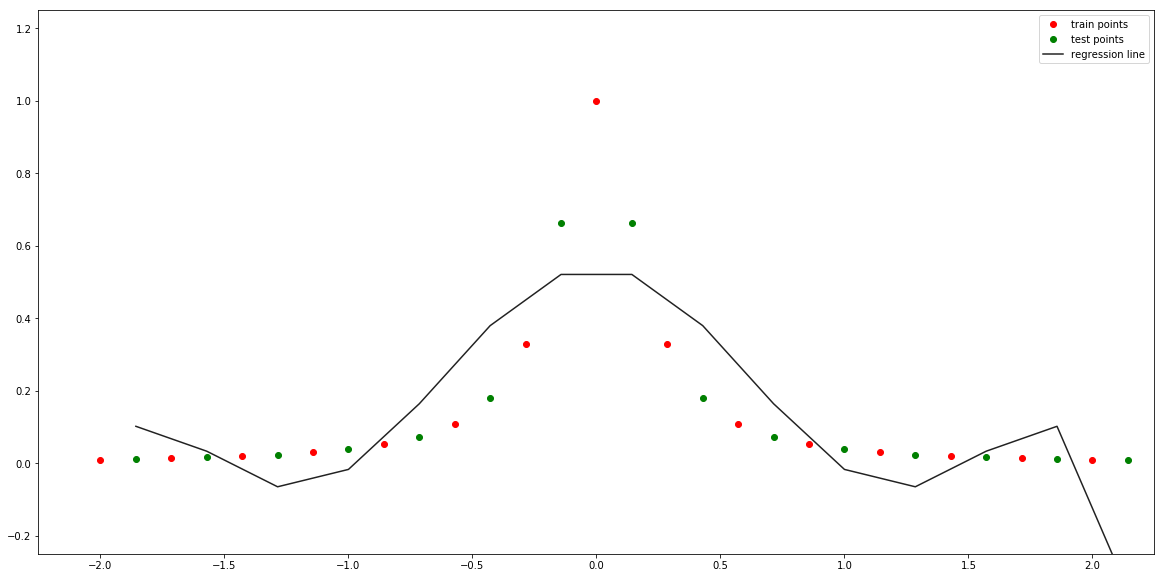

In [18]:
polynomial_regression_test(func_1['X_train'],func_1['Y_train'],func_1['X_test'],func_1['Y_test'],7)

## IV. Spline approx